In [27]:
import pandas as pd
import numpy as np

from keras.layers import Conv1D, Input, GlobalAveragePooling1D, Dense, Dropout
from keras.models import Model
from keras import regularizers

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [28]:
# Load data
bankdata = pd.read_csv('/Users/zojaanzur/Downloads/hooseok_dataset_processed.csv')

print('Shape of the dataset: {}'.format(bankdata.shape))
print('The dataset contains data from {} subjects'.format(len(bankdata["subject"].unique())))

Shape of the dataset: (9888, 505)
The dataset contains data from 24 subjects


In [29]:
# EDA - missing values
missing_values = bankdata.isna().sum()

print('Max number of missing values in 1 column:')
print(missing_values.max())

Max number of missing values in 1 column:
0


In [30]:
# EDA - categorical variables
print(bankdata['activity'].value_counts())
print(bankdata['label'].value_counts(normalize=True) * 100) # class imbalance

activity
Walking 2.5km/h    2880
Running 6km/h      2160
Running 7km/h      2160
Walking 3km/h      1440
Resting            1248
Name: count, dtype: int64
label
0    81.978155
1    18.021845
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Visualisation of row 1')

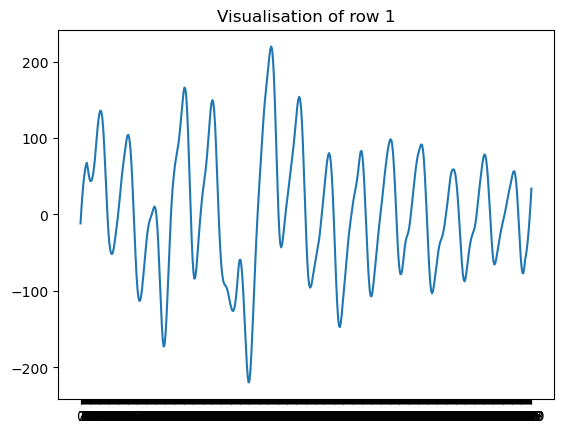

In [31]:
# EDA - visualisation
plt.plot(bankdata.iloc[1, 5:])
plt.title('Visualisation of row 1')


In [32]:
# Calculate heart-rate (HR) from PPG 

# f = 50 Hz = we take 50 measurements per second
# There is 500 columns in 1 row -> 500 / 50 = 10 seconds in 1 row
# HR = no. of peaks in PPG signal * 6 for each for 

# Find peaks for every row
from scipy.signal import find_peaks

bankdata['HR'] = [(len(find_peaks(bankdata.iloc[x, 5:])[0])) * 6 for x in range(len(bankdata))]

In [33]:
# Check max and min HR in dataset
max_hr = bankdata['HR'].max()
min_hr = bankdata['HR'].min()

print('Max HR = {} \nMin HR = {}'.format(max_hr, min_hr))

Max HR = 222 
Min HR = 60


In [34]:
# Calculate mean HR for each subject and activity
mean_hr = bankdata.groupby(['subject', 'activity'])['HR'].mean().reset_index()
print(mean_hr)

     subject         activity          HR
0          1          Resting  138.923077
1          1    Running 6km/h  135.133333
2          1    Running 7km/h  142.200000
3          1  Walking 2.5km/h  125.450000
4          1    Walking 3km/h  134.800000
..       ...              ...         ...
115       24          Resting   81.576923
116       24    Running 6km/h  113.866667
117       24    Running 7km/h  123.266667
118       24  Walking 2.5km/h  107.450000
119       24    Walking 3km/h  113.200000

[120 rows x 3 columns]


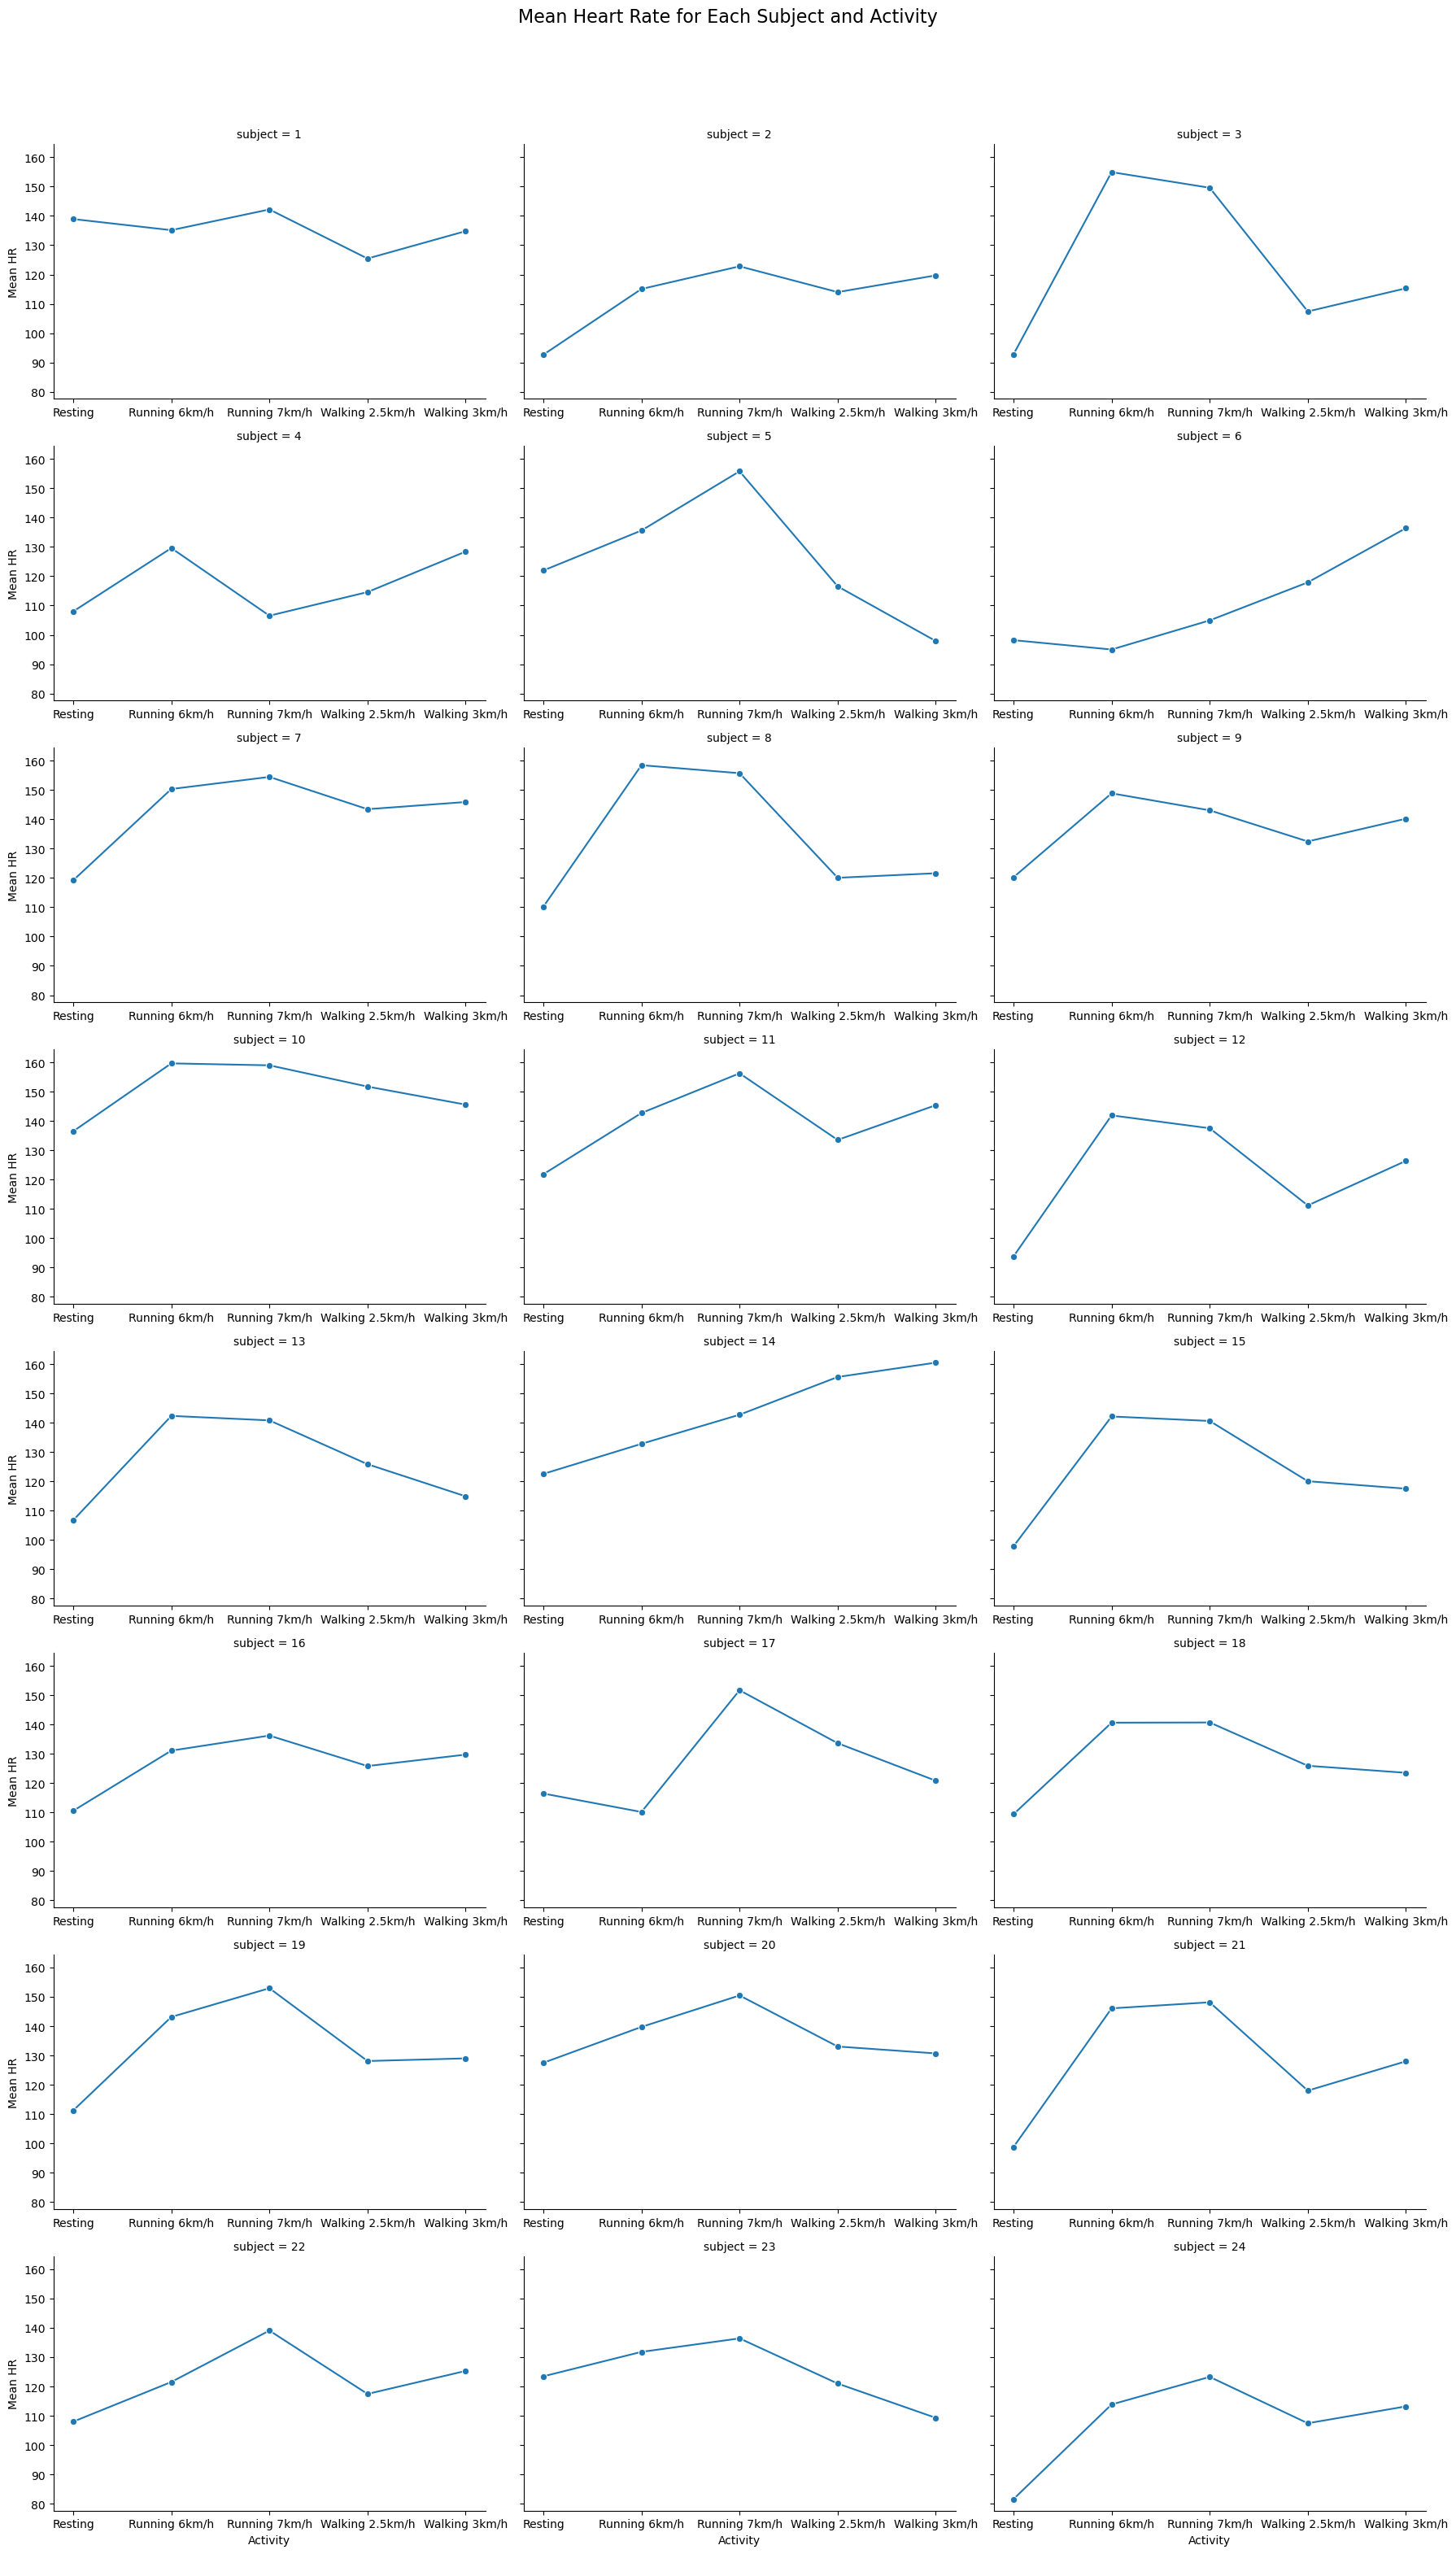

In [35]:
# Create the FacetGrid
g = sns.FacetGrid(mean_hr, col="subject", col_wrap=3, height=4, aspect=1.5, sharex=False)

# Map the lineplot to each facet
g.map(sns.lineplot, "activity", "HR", marker="o")

# Set axis labels
g.set_axis_labels("Activity", "Mean HR")

# Add a title to the entire grid
g.fig.suptitle('Mean Heart Rate for Each Subject and Activity', fontsize=16)
g.fig.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

In [36]:
# Build deep learning model for predicting label

# Split data to train, validation, test
# Split by subject to prevent overfitting
train = bankdata[bankdata.subject.between(1, 16)]
test = bankdata[bankdata.subject.between(17, 20)]
valid = bankdata[bankdata.subject.between(21, 24)]

train_X = train.iloc[:, 5:-1]
train_y = train.iloc[:, 4]

test_X = test.iloc[:, 5:-1]
test_y = test.iloc[:, 4]

valid_X = valid.iloc[:, 5:-1]
valid_y = valid.iloc[:, 4]

In [37]:
def create_model(input_shape, numFilters, kernelSize, reg_strength=0.01, dropout_rate=0.5):
    # Input layer
    inp = Input(shape=input_shape, name="main_input")

    # First convolutional layer
    conv1 = Conv1D(filters=numFilters, kernel_size=kernelSize, padding="causal", activation="relu",
                   kernel_regularizer=regularizers.L2(reg_strength))(inp)

    # Second convolutional layer with dilation rate
    conv2 = Conv1D(filters=numFilters, kernel_size=kernelSize, dilation_rate=2, padding="causal", activation="relu",
                   kernel_regularizer=regularizers.L2(reg_strength))(conv1)

    # Third convolutional layer with increased dilation rate
    conv3 = Conv1D(filters=numFilters, kernel_size=kernelSize, dilation_rate=4, padding="causal", activation="relu",
                   kernel_regularizer=regularizers.L2(reg_strength))(conv2)

    # Fourth convolutional layer with increased dilation rate
    conv4 = Conv1D(filters=numFilters, kernel_size=kernelSize, dilation_rate=8, padding="causal", activation="relu",
                   kernel_regularizer=regularizers.L2(reg_strength))(conv3)

    # Fifth convolutional layer with increased dilation rate
    conv5 = Conv1D(filters=numFilters, kernel_size=kernelSize, dilation_rate=16, padding="causal", activation="relu",
                   kernel_regularizer=regularizers.L2(reg_strength))(conv4)

    # Global Average Pooling layer
    gap = GlobalAveragePooling1D()(conv5)

    # Dropout layer for regularization
    dropout = Dropout(dropout_rate)(gap)

    # Dense output layer
    output = Dense(1, activation="sigmoid")(dropout)

    # Model definition
    model = Model(inputs=inp, outputs=output)

    # Model compilation
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    # Return the compiled model
    return model

In [38]:
# Model parameters
numFilters = 16
kernelSize = 3
reg_strength = 0.01
input_shape = (500, 1)

# Create model 
model = create_model(input_shape, numFilters, kernelSize, reg_strength)

# Model summary
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 500, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 500, 16)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 500, 16)        │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 500, 16)        │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 500, 16)        │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 500, 16)        │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,217 (12.57 KB)

 Trainable params: 3,217 (12.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7279 - loss: 1.4192 - val_accuracy: 0.8410 - val_loss: 0.8419
Epoch 2/300
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8179 - loss: 0.8643 - val_accuracy: 0.8410 - val_loss: 0.6883
Epoch 3/300
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8248 - loss: 0.7207 - val_accuracy: 0.8410 - val_loss: 0.5970
Epoch 4/300
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8366 - loss: 0.6279 - val_accuracy: 0.8410 - val_loss: 0.5648
Epoch 5/300
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8242 - loss: 0.5807 - val_accuracy: 0.8410 - val_loss: 0.5148
Epoch 6/300
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8420 - loss: 0.5440 - val_accuracy: 0.8410 - val_loss: 0.4804
Epoch 7/300
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8427 - loss: 0.5097 - val_accuracy: 0.8471 - val_loss: 0.4589
Epoch 8/300
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8434 - loss: 0.4870 - 

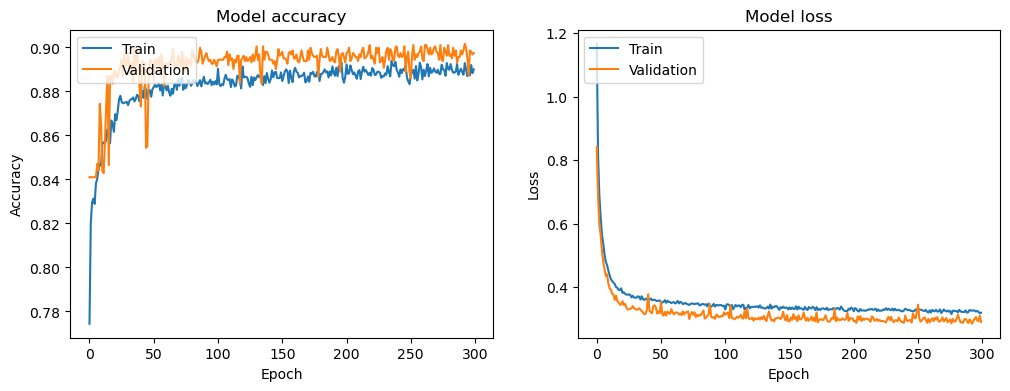

In [39]:
# Reshape the data to fit the input shape of the model
train_data = np.expand_dims(train_X.values, axis=2)
test_data = np.expand_dims(test_X.values, axis=2)
val_data = np.expand_dims(valid_X.values, axis=2)

# Training the model
history = model.fit(
    train_data, train_y,
    epochs=300,
    batch_size=32,
    validation_data=(val_data, valid_y)
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data, test_y)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plotting the training and validation loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


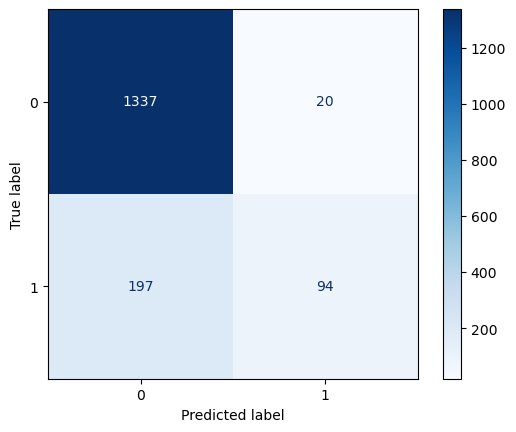

In [40]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(test_data)
predicted_labels = (y_pred > 0.5).astype(int).flatten()

cm = confusion_matrix(test_y, predicted_labels)  # y_test are the true labels

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Despite reaching high accuracy, our model is not good. As seen from the confusion matrix, the model classifies everything into class 0, hence the high accuracy. This is probably due to class imbalance in train data (80 % labeled 0).

We will continue with applying class weights to reduce the effect of the class imbalance.

In [41]:
# Applying class weights
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(train_y), 
                                                  y=train_y)

# Dict with class weights
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(class_weight_dict)

{0: 0.614581391012493, 1: 2.6818551668022783}


In [42]:
# Model parameters
numFilters = 16
kernelSize = 3
reg_strength = 0.01
input_shape = (500, 1)

# Create model 
model_weights = create_model(input_shape, numFilters, kernelSize, reg_strength)

# Model summary
model_weights.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 500, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 500, 16)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 500, 16)        │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 500, 16)        │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 500, 16)        │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 500, 16)        │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,217 (12.57 KB)

 Trainable params: 3,217 (12.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5235 - loss: 1.2929 - val_accuracy: 0.8453 - val_loss: 0.9406
Epoch 2/300
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6680 - loss: 0.9361 - val_accuracy: 0.6802 - val_loss: 0.8538
Epoch 3/300
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7039 - loss: 0.8252 - val_accuracy: 0.8586 - val_loss: 0.6787
Epoch 4/300
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7473 - loss: 0.7632 - val_accuracy: 0.8040 - val_loss: 0.6774
Epoch 5/300
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7509 - loss: 0.7264 - val_accuracy: 0.8489 - val_loss: 0.5888
Epoch 6/300
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7755 - loss: 0.6940 - val_accuracy: 0.8404 - val_loss: 0.5804
Epoch 7/300
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7833 - loss: 0.6375 - val_accuracy: 0.8623 - val_loss: 0.5368
Epoch 8/300
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7995 - loss: 0.6298 - 

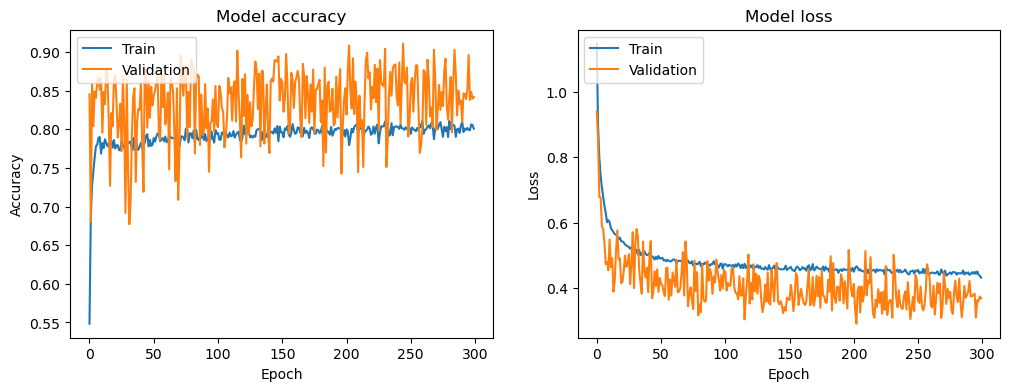

In [43]:
# Training the model
history_weights = model_weights.fit(
    train_data, train_y,
    epochs=300,
    batch_size=32,
    validation_data=(val_data, valid_y), 
    class_weight=class_weight_dict
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data, test_y)
print(f"Test Loss: {test_loss}")
print(f"Test F1: {test_accuracy}")

# Plotting the training and validation loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_weights.history["accuracy"])
plt.plot(history_weights.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_weights.history["loss"])
plt.plot(history_weights.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


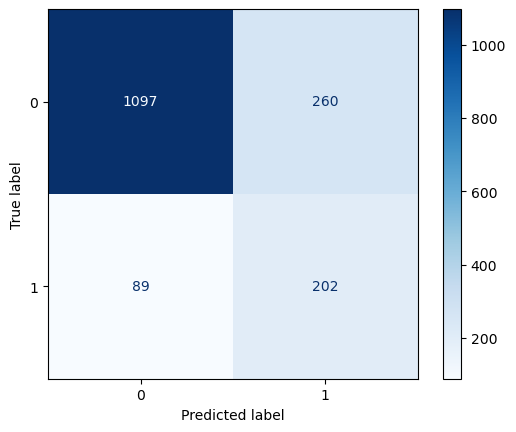

In [46]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_weights = model_weights.predict(test_data)
predicted_labels_weights = (y_pred_weights > 0.5).astype(int).flatten()

cm = confusion_matrix(test_y, predicted_labels_weights)  # y_test are the true labels

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [48]:
# Other evaluation metrics 
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(test_y, predicted_labels_weights))
auc = roc_auc_score(test_y, predicted_labels_weights)
print(f'AUC-ROC: {auc}')


              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1357
           1       0.44      0.69      0.54       291

    accuracy                           0.79      1648
   macro avg       0.68      0.75      0.70      1648
weighted avg       0.84      0.79      0.81      1648

AUC-ROC: 0.7512794799524928


The model performs very well on class 0 but has a lower performance on class 1, despite attempts to reduce the class imbalance.The overall accuracy is good at 79%, but the relatively lower F1 score for class 1 and the difference in precision and recall suggest some difficulty in correctly classifying this minority class.

The AUC-ROC score of 0.75 is a positive indication that the model is fairly effective at distinguishing between the two classes.

THIS WORK IS STILL IN PROGRES ... 

Next step:
- experiment with different weights